In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def poly2_poly4_compare(x, y, *, scatter_kwargs=None, line_kwargs=None):
    """
    Fit y = a*x^2 + c and y = a*x^4 + c to (x, y) data and plot the fits
    with residuals.

    Parameters
    ----------
    x, y : 1-dimensional array-like
        Input and output data of equal length.
    scatter_kwargs, line_kwargs : dict, optional
        Extra keyword arguments forwarded to `ax.scatter` and `ax.plot`
        (e.g. marker size, alpha, linestyle).

    Returns
    -------
    (a2, c2), (a4, c4) : tuple of fit parameters
        Best-fit coefficients for the quadratic and quartic models.
    """

    x   = np.asarray(x, dtype=float).ravel()
    y   = np.asarray(y, dtype=float).ravel()
    N   = len(x)
    if len(y) != N:
        raise ValueError("x and y must have the same length")

    # --- helper for linear least-squares with one basis function + constant
    def fit_basis(basis):
        M   = np.vstack([basis, np.ones_like(x)]).T         # design matrix
        coeff, *_ = np.linalg.lstsq(M, y, rcond=None)       # [a, c]
        y_hat   = M @ coeff
        resid   = y - y_hat
        r2      = 1.0 - resid.dot(resid) / np.square(y - y.mean()).sum()
        return coeff, y_hat, resid, r2

    (a2, c2), y2, r2_resid, R2_quad = fit_basis(x**2)
    (a4, c4), y4, r4_resid, R2_quar = fit_basis(x**4)

    # ---------- Plotting ----------
    scatter_kwargs = scatter_kwargs or dict(s=25, alpha=0.8)
    line_kwargs    = line_kwargs    or dict(lw=2)

    fig = plt.figure(constrained_layout=True, figsize=(10, 5))
    gs  = GridSpec(2, 2, height_ratios=[3, 1], figure=fig)

    # Quadratic fit (left)
    ax_q = fig.add_subplot(gs[0, 0])
    ax_q.scatter(x, y, label="data", **scatter_kwargs)
    ax_q.plot(np.sort(x), y2[np.argsort(x)], label=f"fit  $R^2={R2_quad:.4f}$", **line_kwargs)
    ax_q.set_title(r"$y = a_2 x^2 + c_2$")
    ax_q.legend()
    ax_q.set_ylabel("y")

    # Quartic fit (right)
    ax_4 = fig.add_subplot(gs[0, 1])
    ax_4.scatter(x, y, label="data", **scatter_kwargs)
    ax_4.plot(np.sort(x), y4[np.argsort(x)], label=f"fit  $R^2={R2_quar:.4f}$", **line_kwargs)
    ax_4.set_title(r"$y = a_4 x^4 + c_4$")
    ax_4.legend()

    # Residuals
    ax_qr = fig.add_subplot(gs[1, 0], sharex=ax_q)
    ax_qr.axhline(0, lw=0.8, color="k")
    ax_qr.scatter(x, r2_resid, **scatter_kwargs)
    ax_qr.set_xlabel("x")
    ax_qr.set_ylabel("residual")

    ax_4r = fig.add_subplot(gs[1, 1], sharex=ax_4)
    ax_4r.axhline(0, lw=0.8, color="k")
    ax_4r.scatter(x, r4_resid, **scatter_kwargs)
    ax_4r.set_xlabel("x")

    plt.show()

    return (a2, c2), (a4, c4)


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def fit_cosine_model(x, y, U, *, scatter_kwargs=None, line_kwargs=None):
    """
    Fit y = 2U - a/U + b/U^3*cos(x) + c/U^3*cos(2x) to (x, y) data 
    for fixed U, and plot the fit with residuals.

    Parameters
    ----------
    x, y : array-like, shape (N,)
        Independent and dependent data.
    U : float
        Fixed U parameter in the model.
    scatter_kwargs : dict, optional
        Passed to ax.scatter (e.g. marker size, alpha).
    line_kwargs : dict, optional
        Passed to ax.plot (e.g. linewidth, linestyle).

    Returns
    -------
    (a, b, c), R2 : tuple
        Best‑fit parameters a, b, c and coefficient of determination R².
    """
    x = np.asarray(x, float).ravel()
    y = np.asarray(y, float).ravel()
    if x.shape != y.shape:
        raise ValueError("x and y must have the same shape")

    # design matrix columns: [-1/U, cos(x)/U^3, cos(2x)/U^3]
    M = np.vstack([
        -np.ones_like(x) / U,
         np.cos(x)      / U**3,
         np.cos(2*x)    / U**3,
    ]).T

    # prepend constant term 2U
    # we handle that by subtracting it from y before fitting:
    y_adj = y - 2*U

    # solve least-squares for [a, b, c]
    coeffs, *_ = np.linalg.lstsq(M, y_adj, rcond=None)
    a, b, c = coeffs

    # compute fit, residuals, R^2
    y_hat = 2*U + M.dot(coeffs)
    resid = y - y_hat
    ss_res = np.dot(resid, resid)
    ss_tot = np.dot(y - y.mean(), y - y.mean())
    R2     = 1 - ss_res/ss_tot

    # plotting
    scatter_kwargs = scatter_kwargs or dict(s=25, alpha=0.8)
    line_kwargs    = line_kwargs    or dict(lw=2)

    fig = plt.figure(constrained_layout=True, figsize=(8, 5))
    gs  = GridSpec(2, 1, height_ratios=[3, 1], figure=fig)

    # top: data + fit
    ax0 = fig.add_subplot(gs[0])
    ax0.scatter(x, y, label="data", **scatter_kwargs)
    # plot the fit as a smooth line
    xs = np.linspace(x.min(), x.max(), 500)
    ys = 2*U + (
        -a/U 
        + b*np.cos(xs)/U**3 
        + c*np.cos(2*xs)/U**3
    )
    ax0.plot(xs, ys, label=f"fit  $R^2={R2:.4f}$", **line_kwargs,color="black",alpha=.4)
    ax0.set_title(r"$y = 2U - \frac{a}{U} + \frac{b}{U^3}\cos x + \frac{c}{U^3}\cos2x$")
    ax0.legend()
    ax0.set_ylabel("y")

    # bottom: residuals
    ax1 = fig.add_subplot(gs[1], sharex=ax0)
    ax1.axhline(0, color='k', lw=0.8)
    ax1.scatter(x, resid, **scatter_kwargs)
    ax1.set_xlabel("x")
    ax1.set_ylabel("residual")

    plt.show()

    return (a, b, c), R2


In [53]:
N_K = 201
K_values = np.linspace(-np.pi/8, np.pi/8, N_K)
data = np.load('060725_bands_combined_quad.npy')
bound_band = data.T[-3]

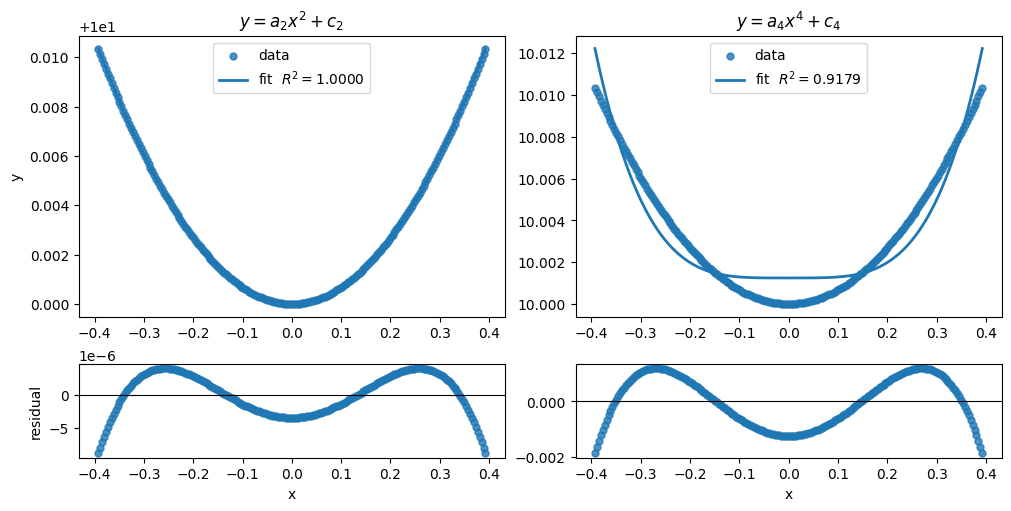

((np.float64(0.06710579913055666), np.float64(10.000003443203491)),
 (np.float64(0.4615354467391152), np.float64(10.00124820539451)))

In [54]:
poly2_poly4_compare(K_values,bound_band)

In [56]:
N_K = 401
K_values = np.linspace(-np.pi, np.pi, N_K)
data = np.load('080725_bands_combined.npy')
bound_band = data.T[-3]

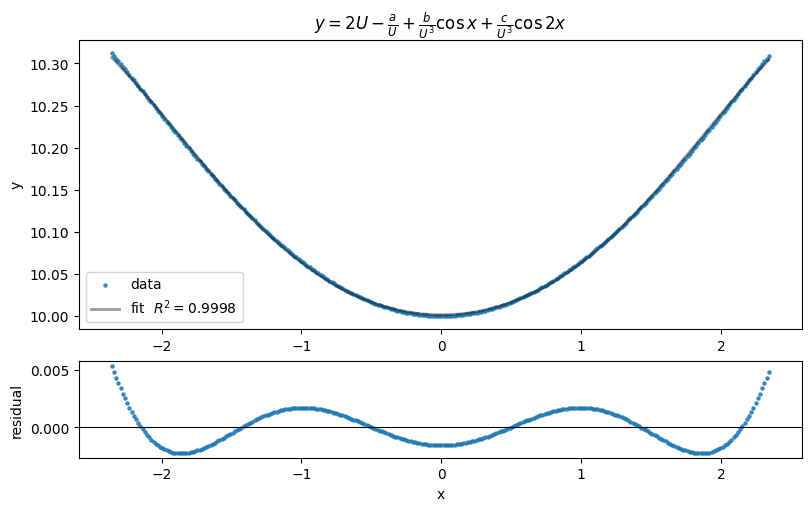

((np.float64(98.2693751405595),
  np.float64(-189.28421385655957),
  np.float64(17.771298051361832)),
 np.float64(0.99975054269003))

In [58]:
fit_cosine_model(K_values[50:350],bound_band[50:350],10, scatter_kwargs={'s': 5, 'alpha': 0.8},)

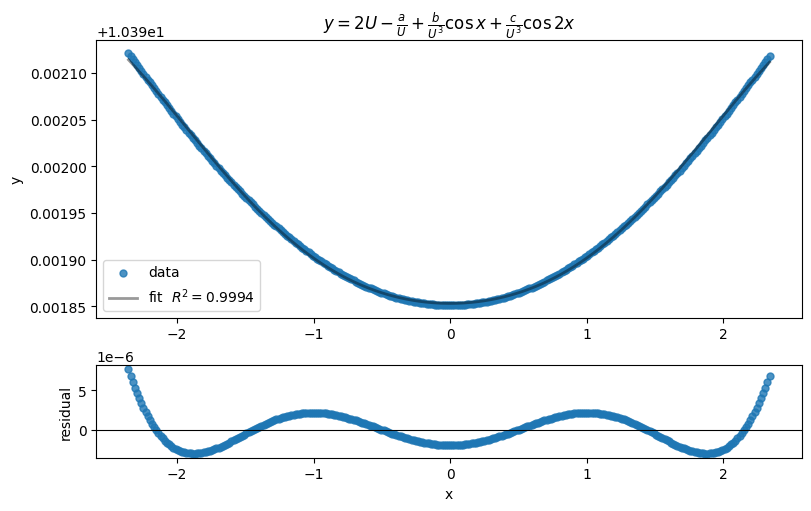

((np.float64(96.08001759020344),
  np.float64(-0.1639069491527396),
  np.float64(0.01894405520659785)),
 np.float64(0.9993832200070312))

In [59]:
bound_band = data.T[-2]
fit_cosine_model(K_values[50:350],bound_band[50:350],10)

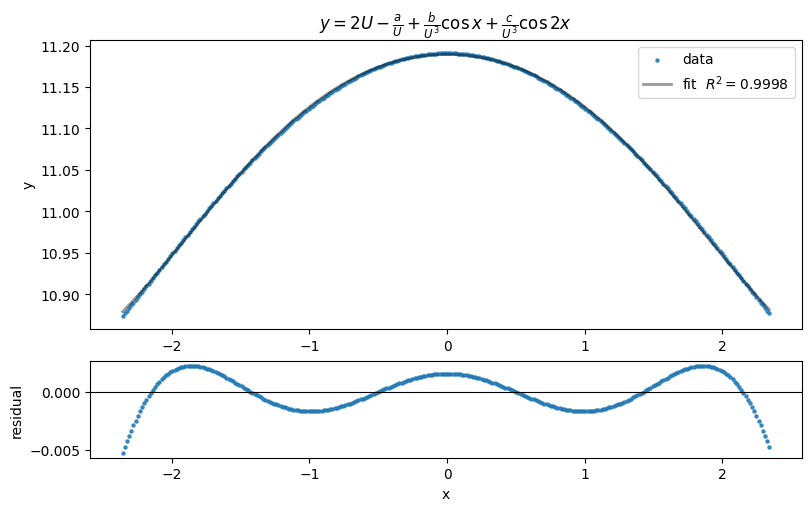

((np.float64(89.8506582772901),
  np.float64(192.01922078009062),
  np.float64(-17.680246743505634)),
 np.float64(0.9997601225866706))

In [61]:
bound_band = data.T[-1]
fit_cosine_model(K_values[50:350],bound_band[50:350],10, scatter_kwargs={'s': 5, 'alpha': 0.8},)